In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import datajoint as dj
import h5py
import sys
import pandas as pd
import shutil
import pickle
import jaxley as jx

from djimaging.user.alpha.utils import database

# Set these to change what cell you want
date = "2020-08-29"
stimulus = "noise_1500"
exp_num = "1"
cell_id = date + "_" + exp_num
field_stim_extract = "d1"  # Assume stimuli are all the same with each ROI


# Get the current working directory
cwd = os.getcwd()

# Get the username
username = os.popen('whoami').read().strip()

# Get the home directory
home_directory = os.path.expanduser("~")
print(username, home_directory)

# Set the path to the data directory where results will be stored
base_dir = f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
assert os.path.exists(base_dir), f'{base_dir} does not exist.'
  

/gpfs01/euler/User/ssuhai/GitRepos/s-on-alpha-regional/code/AlphaDjimaging/djimaging/autorois/roi_canvas.py:24: UserWarning: Failed to import ipycanvas. AutoROIs will not work.
  warnings.warn('Failed to import ipycanvas. AutoROIs will not work.')


ssuhai /gpfs01/euler/User/ssuhai


In [2]:
file1 = h5py.File('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/data/SMP_C1_d2_Dnoise.h5', 'r')
noise_stimulus1 = file1["NoiseArray3D"][()]
file2 = h5py.File('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/data/noise.h5', 'r')
noise_stimulus2 = file2["NoiseArray3D"][()]



In [3]:
# load the labels
base_dir=f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
with open('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/results/data/labels_lowpass_2020-08-29_1.pkl','rb') as handle:
    labels = pickle.load(handle)

In [4]:
def get_rf_from_weighted_image_average(labels,noise_img,rec_id,roi_id,start_idx,stop_idx):
    ca = np.array(labels.loc[(labels['rec_id']==rec_id) & (labels['roi_id']==roi_id)]['ca'].values[0])
    ca = np.array(ca)
    
    weighted_image = noise_img[:,:,start_idx:stop_idx] * ca[np.newaxis,np.newaxis,start_idx:stop_idx] 
    rf = np.mean(weighted_image,axis=2)

    return rf



In [5]:
def get_image_locs(df,uncorrected=False):
    pixel_size = 30
    if uncorrected:
        image_center_x = df["image_center_x_uncorrected"].item()
        image_center_y = df["image_center_y_uncorrected"].item()
    else:
        image_center_x = df["image_center_x"].item()
        image_center_y = df["image_center_y"].item()
    im_pos_x = np.linspace(-7.5*pixel_size + 0.5, 7.5*pixel_size - 0.5, 15*pixel_size) + image_center_x
    im_pos_y = -np.linspace(-10.0*pixel_size + 0.5, 10.0*pixel_size - 0.5, 20*pixel_size) + image_center_y
    return im_pos_x, im_pos_y

In [6]:
def plot_rf_on_morphology(cell,all_df,rec_id,roi_id,cell_id,labels, noise_stimulus,ax,uncorrected=False):
    ax.autoscale(enable=True, axis='both', tight=True) # Add this line
   
    ax.set_aspect('equal', adjustable='box') # Or 'auto' if needed


    df = all_dfs[all_dfs["cell_id"] == cell_id]
    df = df[df["rec_id"] == rec_id]
    df = df[df["roi_id"] == roi_id]

    im_pos_x, im_pos_y = get_image_locs(df,uncorrected=uncorrected)

    cell.vis(ax=ax)

    rf = get_rf_from_weighted_image_average(labels, noise_stimulus, rec_id, roi_id, start_idx=100, stop_idx=1000)

    
    # show rf
    im = ax.imshow(rf.T, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]])
    _ = ax.scatter(
        df["roi_x"],
        df["roi_y"],
        s=20,
        c="red"
    )
    #plt.colorbar(im, ax=ax) # Add this line to create the colorbar. The 'im' argument links it to the image.


/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/utils/misc_utils.py:97: UserWarning: nseg is deprecated and will be removed in version 0.6.0.
  warnings.warn(msg + self._amend_msg)
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:63: UserWarning: Found a segment with length 0. Clipping it to 1.0
  warn("Found a segment with length 0. Clipping it to 1.0")


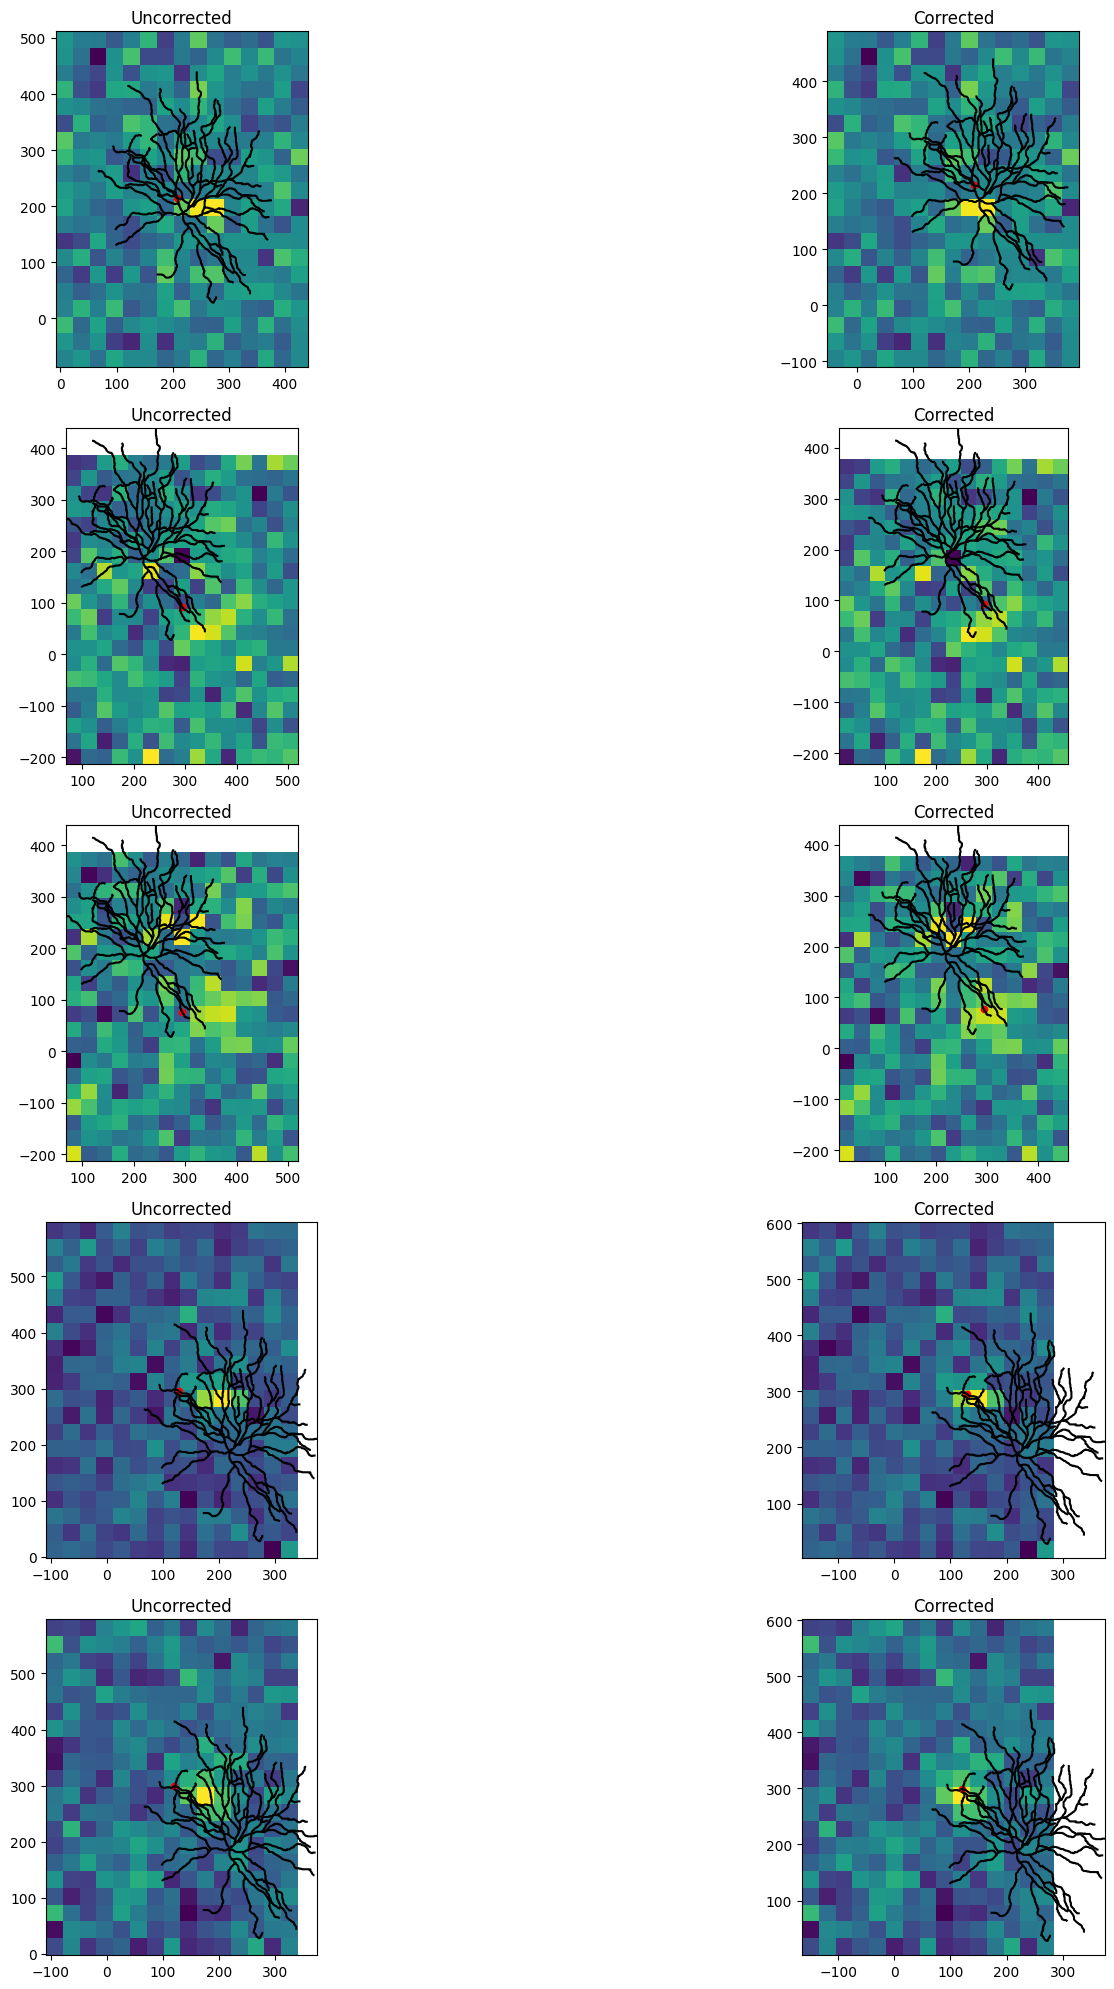

In [7]:
all_dfs = pd.read_pickle(f"{base_dir}/results/data/setup.pkl")
cell = jx.read_swc(f"{base_dir}/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)


    
recs = [0,1,1,2,2]
rois = [3,5,3,2,4]

fig, axes = plt.subplots(len(recs),2,figsize=(20,20))
axes = axes.flatten()
for idx,(rec_id, roi_id) in enumerate(zip(recs,rois)):
    ax = axes[idx*2]
    plot_rf_on_morphology(cell,all_dfs,rec_id=rec_id,roi_id=roi_id,cell_id=cell_id,labels=labels, noise_stimulus=noise_stimulus1,ax=ax,uncorrected=True)
    ax.set_title(f"Uncorrected")

    ax = axes[idx*2 + 1]    
    plot_rf_on_morphology(cell,all_dfs,rec_id=rec_id,roi_id=roi_id,cell_id=cell_id,labels=labels, noise_stimulus=noise_stimulus1,ax=ax,uncorrected=False)
    ax.set_title(f"Corrected")

plt.savefig(
    f"{base_dir}/report_figs/correction_effects_rf_on_morphology_{cell_id}.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.tight_layout()
plt.show()


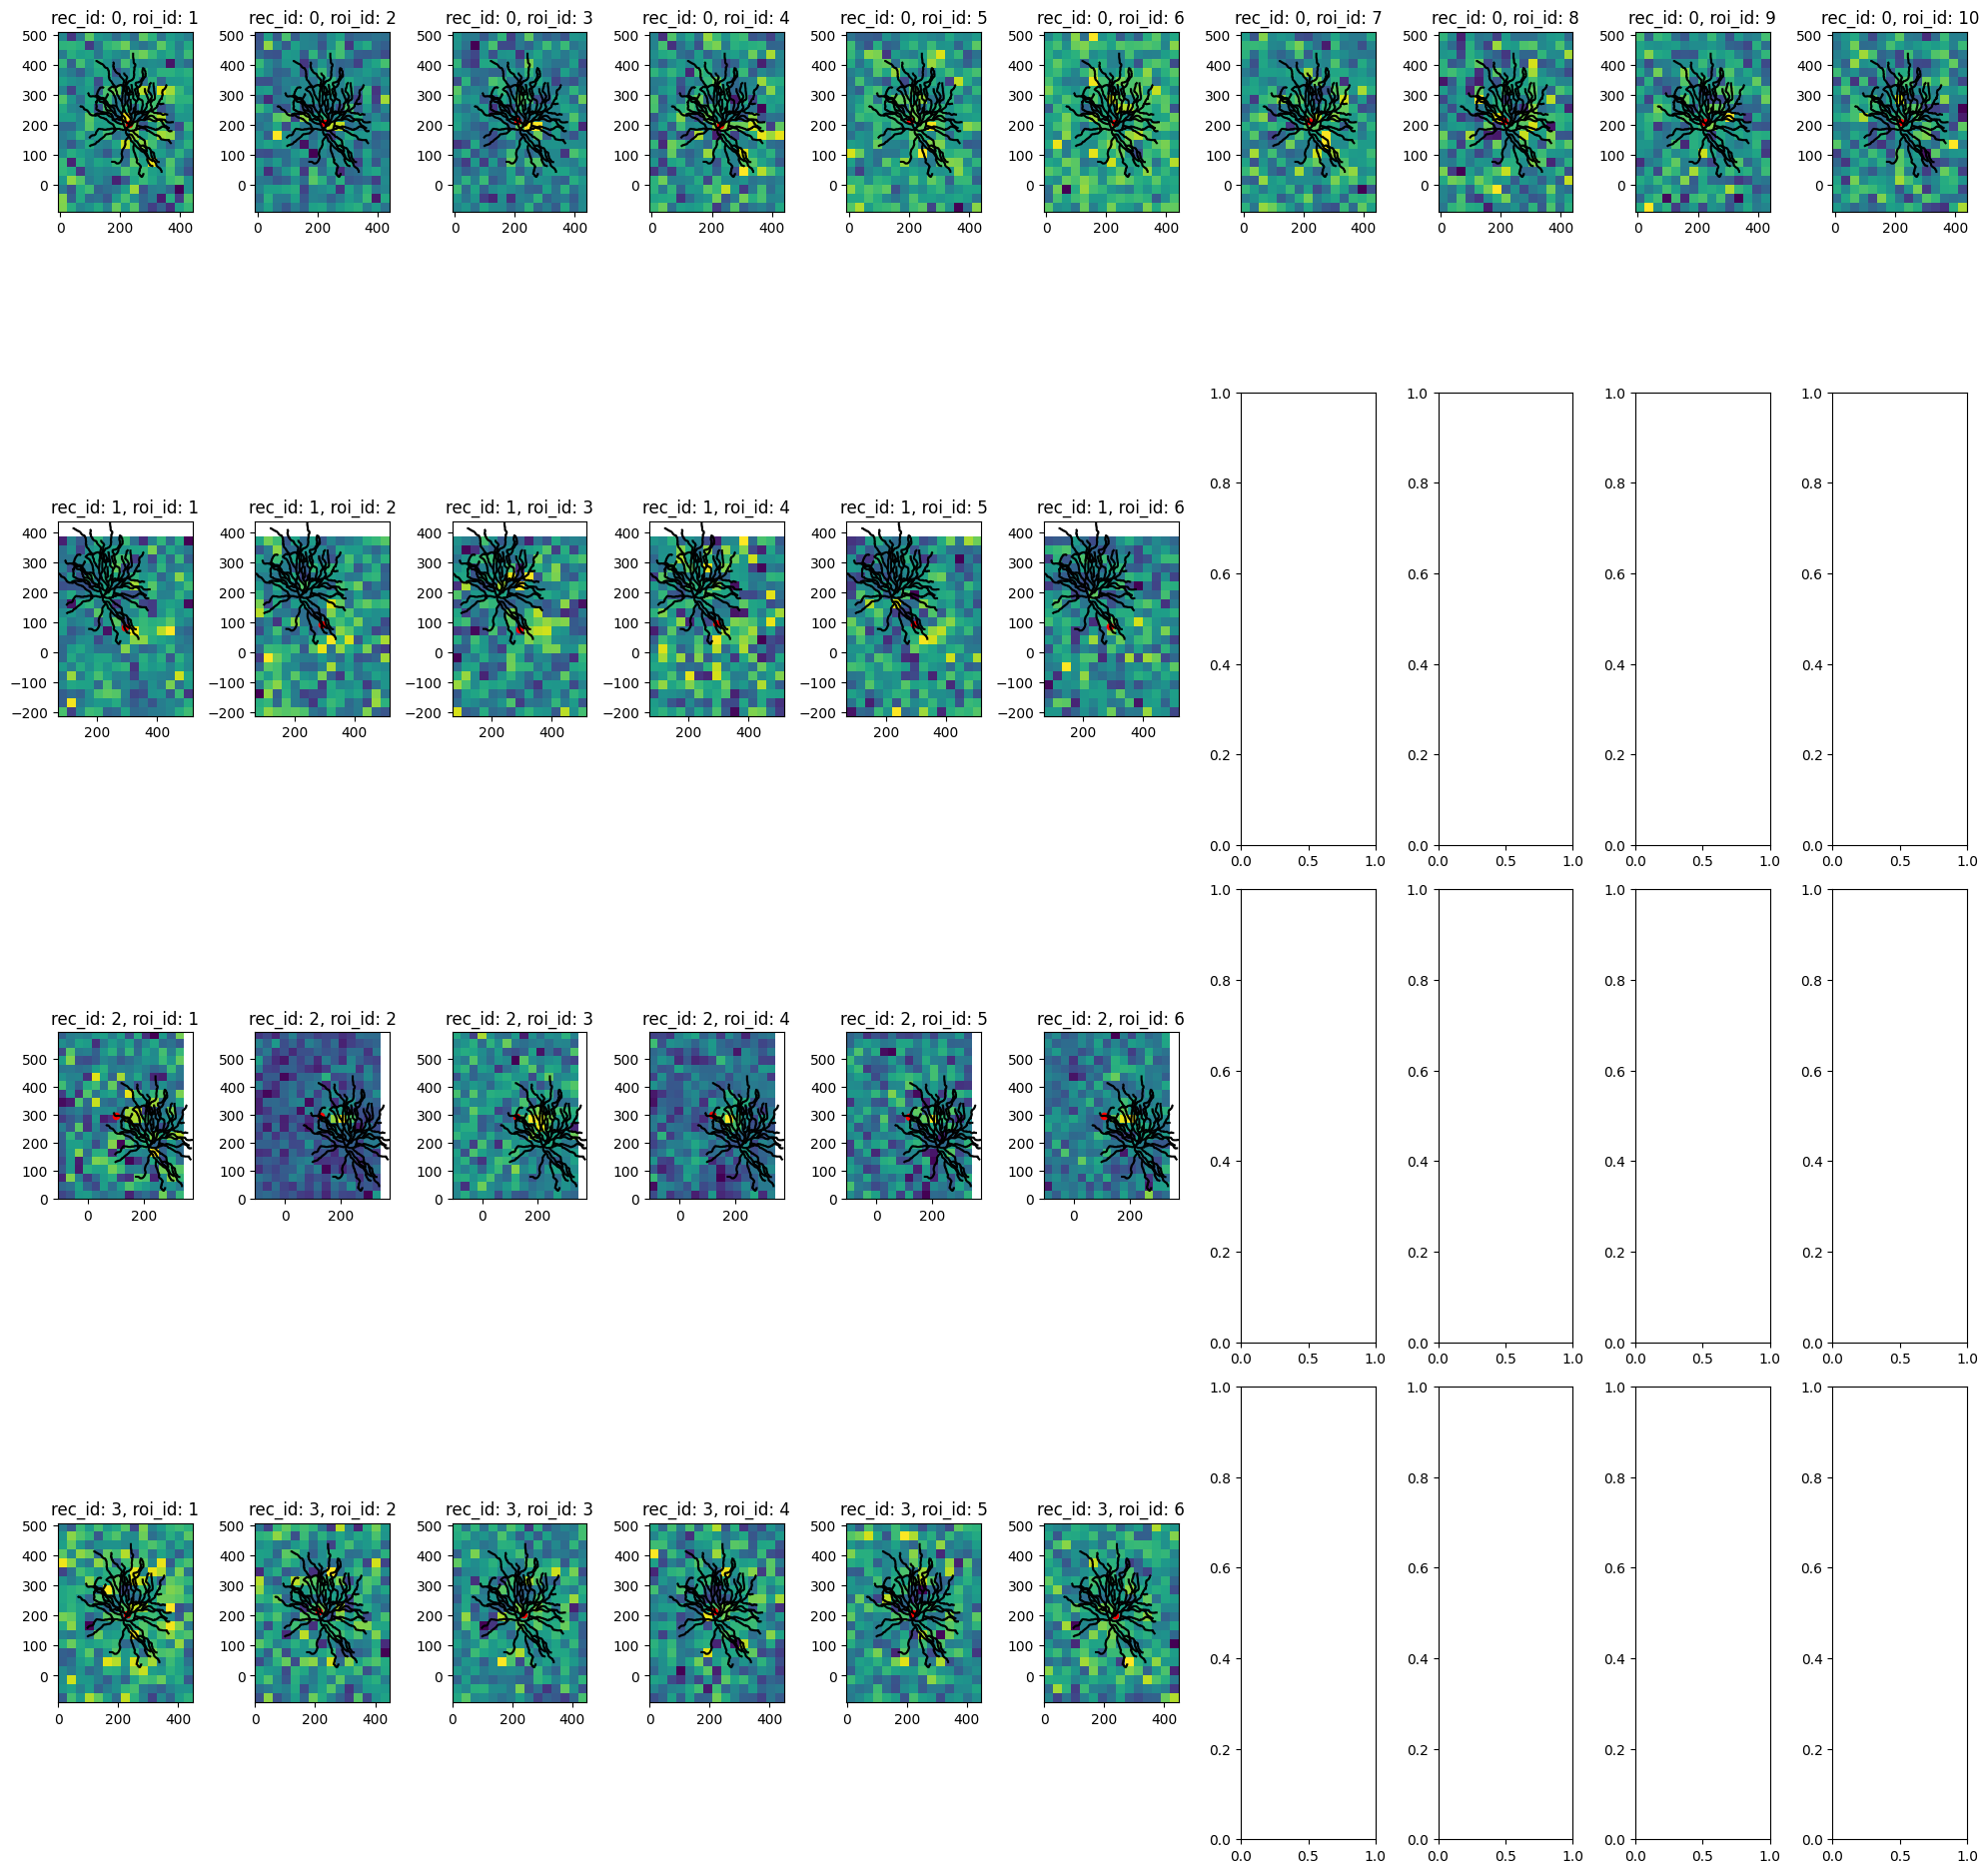

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(20, 20))
#ax = ax.flatten()
for rec_id in range(0, 4):
    max_roi = np.max(labels.loc[labels['rec_id'] == rec_id]['roi_id'].values)

    for roi_id in range(1, max_roi + 1):
        roi_index = roi_id -1
        plot_rf_on_morphology(cell,all_dfs,rec_id=rec_id,roi_id=roi_id,cell_id=cell_id,labels=labels, noise_stimulus=noise_stimulus1,ax=ax[rec_id,roi_index],uncorrected=True)
        ax[rec_id,roi_index].set_title(f'rec_id: {rec_id}, roi_id: {roi_id}')
plt.tight_layout()
plt.show()


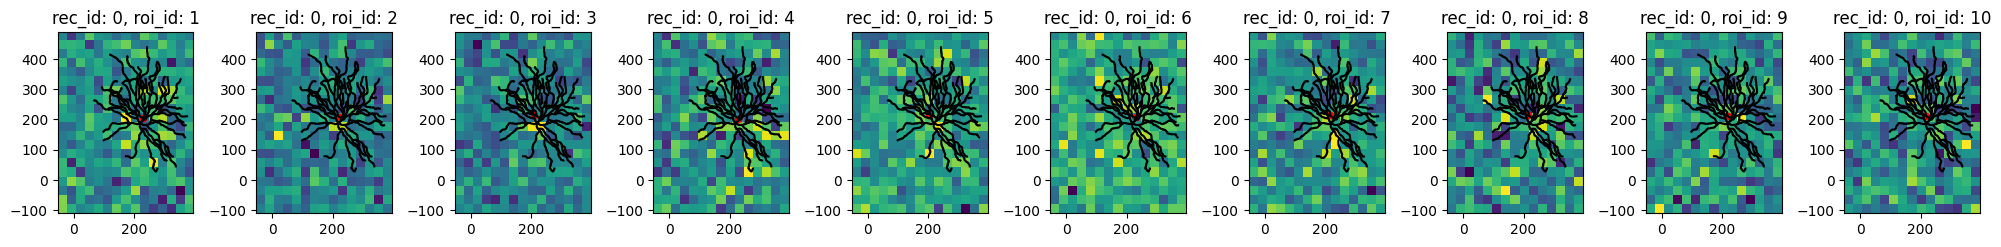

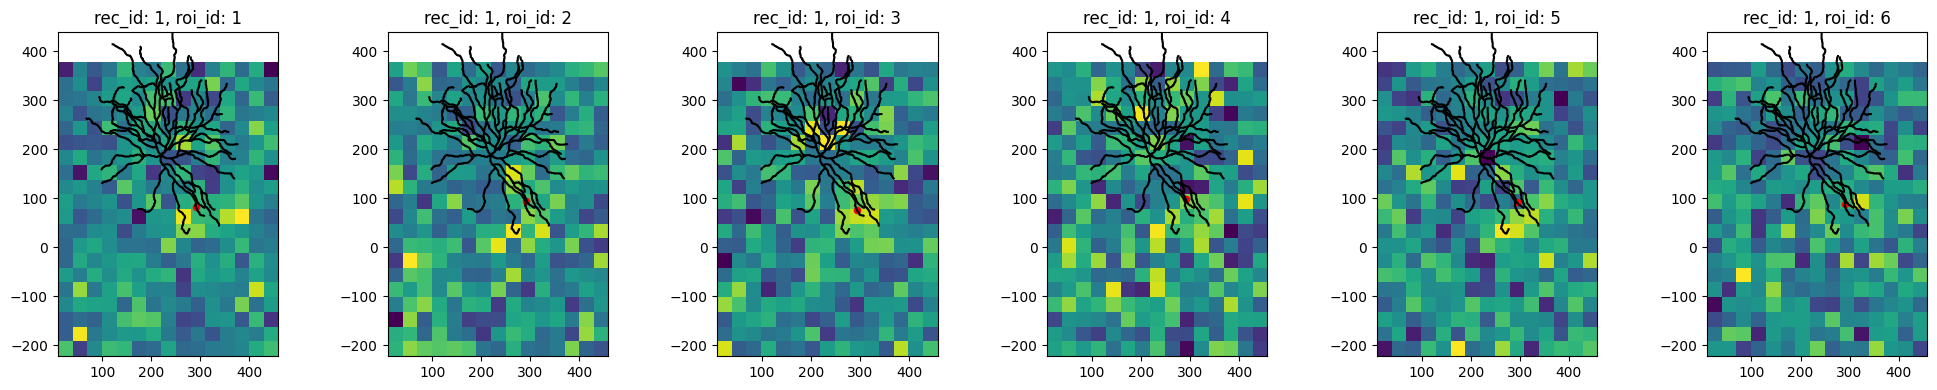

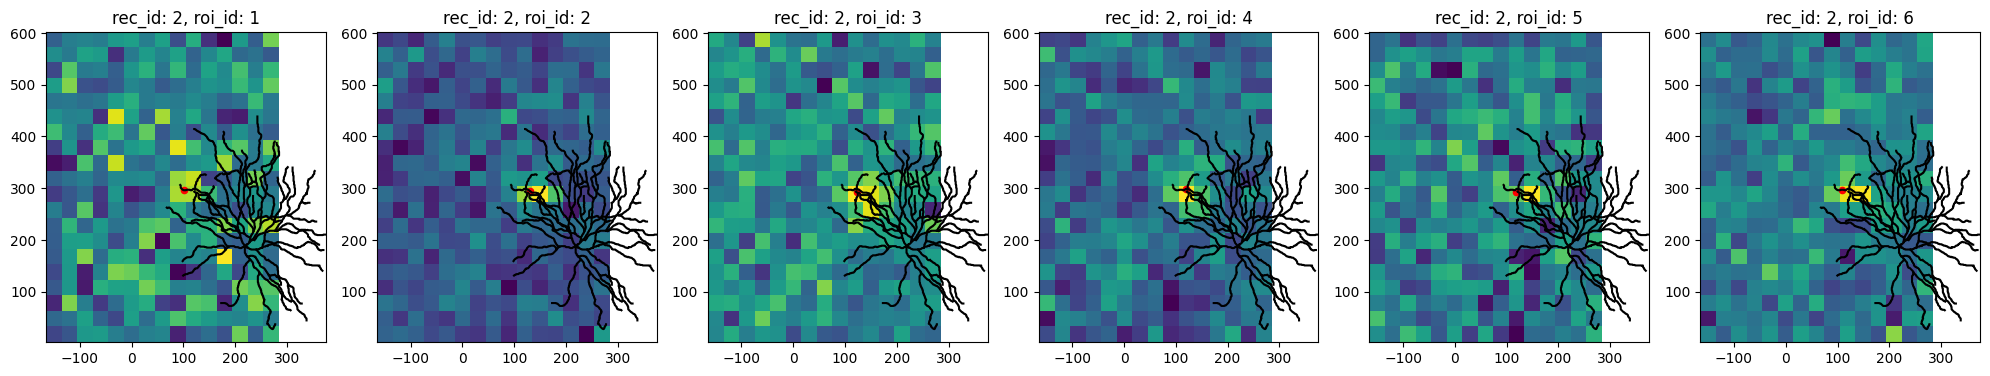

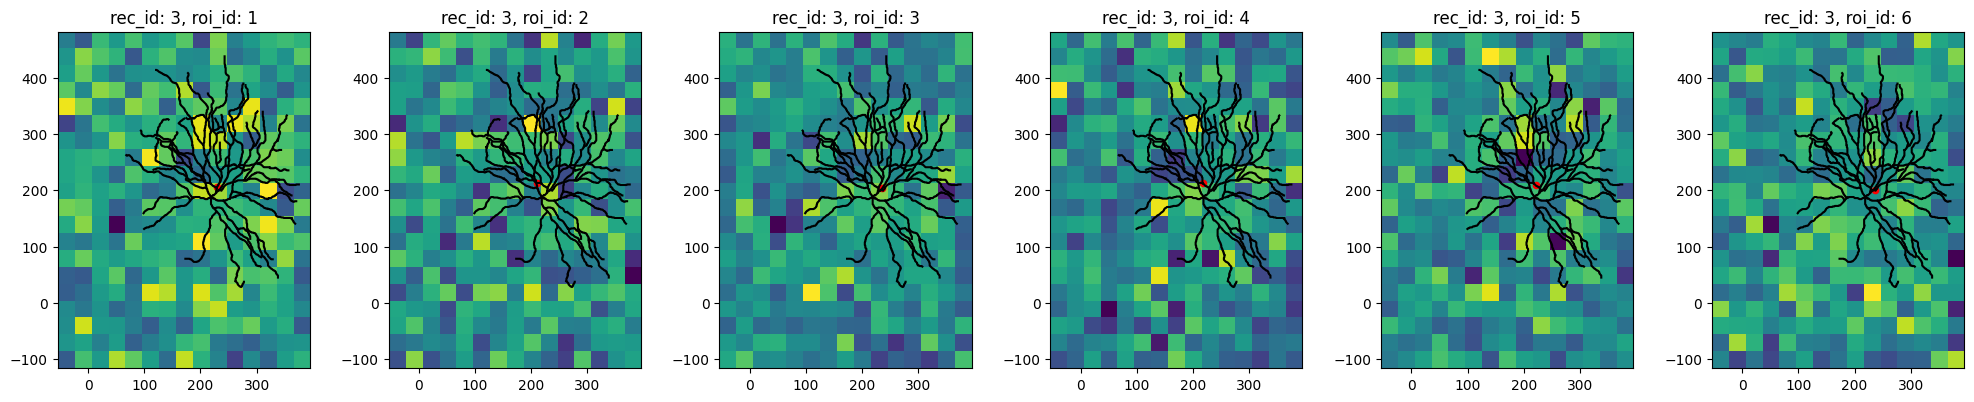

In [17]:
for rec_id in range(0, 4):


    max_roi = np.max(labels.loc[labels['rec_id'] == rec_id]['roi_id'].values)
    fig, ax = plt.subplots(1, max_roi, figsize=(20, 4))
    ax = ax.flatten()
    for roi_id in range(1, max_roi + 1):
        roi_index = roi_id -1
        plot_rf_on_morphology(cell,all_dfs,rec_id=rec_id,roi_id=roi_id,cell_id=cell_id,labels=labels, noise_stimulus=noise_stimulus1,ax=ax[roi_index],uncorrected=False)
        ax[roi_index].set_title(f'rec_id: {rec_id}, roi_id: {roi_id}')
    
    plt.tight_layout()
    plt.savefig(
        f"{base_dir}/report_figs/correction_effects_rf_on_morphology_all_{cell_id}_rec_id_{rec_id}.pdf",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()
